In [1]:
import csv
import collections

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.signal

In [3]:
def read_data(filename, isDP):
    times = []   # sec
    values = []   # L/sec
    with open(filename) as file:
        start_fill = False
        for line in csv.reader(file):
            if start_fill:
                times.append(float(line[1].replace(",", "")))
                if isDP:
                    # calibrate Pa → L/min
                    values.append(np.sign(float(line[2]))*abs(float(line[2]) / 0.0371)**(4.0/7.0))
                else:
                    # convert Pa → cm H₂O
                    values.append(float(line[2]) * 0.0101972)
            if line[0] == "Sample #":
                start_fill = True
    if isDP:
        return collections.namedtuple("TimeFlow", ["time", "flow"])(np.array(times), np.array(values))
    else:
        return collections.namedtuple("TimePressure", ["time", "pressure"])(np.array(times), np.array(values))

DP = read_data("../sample-data/Philippe_DP_sensor3_1.csv", True)
absP = read_data("../sample-data/Philippe_absP_sensor1_1.csv", False)

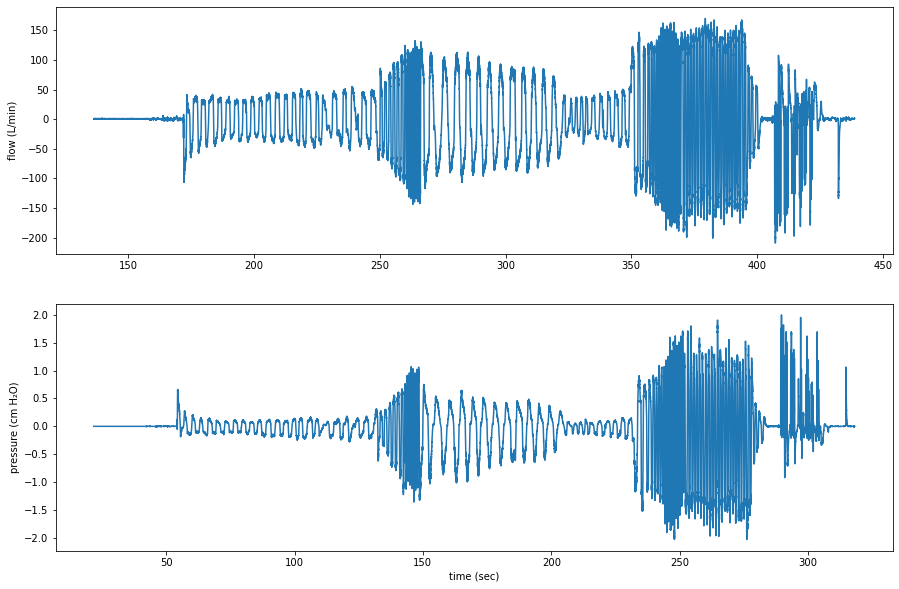

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
ax1.plot(DP.time, DP.flow)
ax1.set_ylabel("flow (L/min)")
ax2.plot(absP.time, absP.pressure)
ax2.set_ylabel("pressure (cm H₂O)")
ax2.set_xlabel("time (sec)")
fig.savefig("Philippe_DP_absP_sensor.png")

In [41]:
def compute_volume(dataset):
    volume = scipy.integrate.cumtrapz(dataset.flow * 1000, dataset.time / 60, initial=0)
    filtered = scipy.signal.sosfilt(scipy.signal.butter(1, 0.001, "highpass", output="sos"), volume)
    return collections.namedtuple("TimeFlowVolume", ["time", "flow", "volume", "filtered"])(
        dataset.time, dataset.flow, volume, filtered)

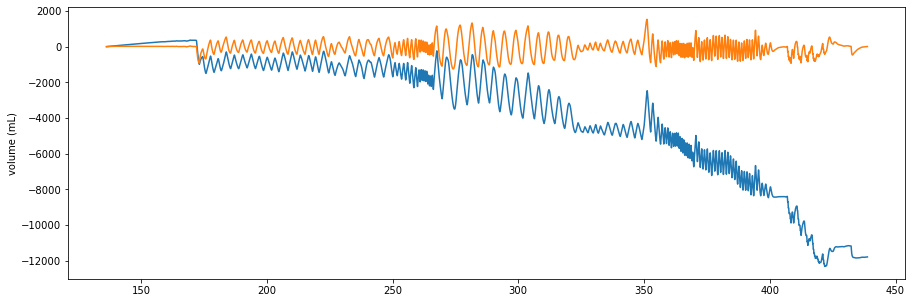

In [42]:
DP2 = compute_volume(DP)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(DP2.time, DP2.volume)
ax.plot(DP2.time, DP2.filtered)
ax.set_ylabel("volume (mL)")
fig.savefig("Philippe_DP_absP_volume.png")

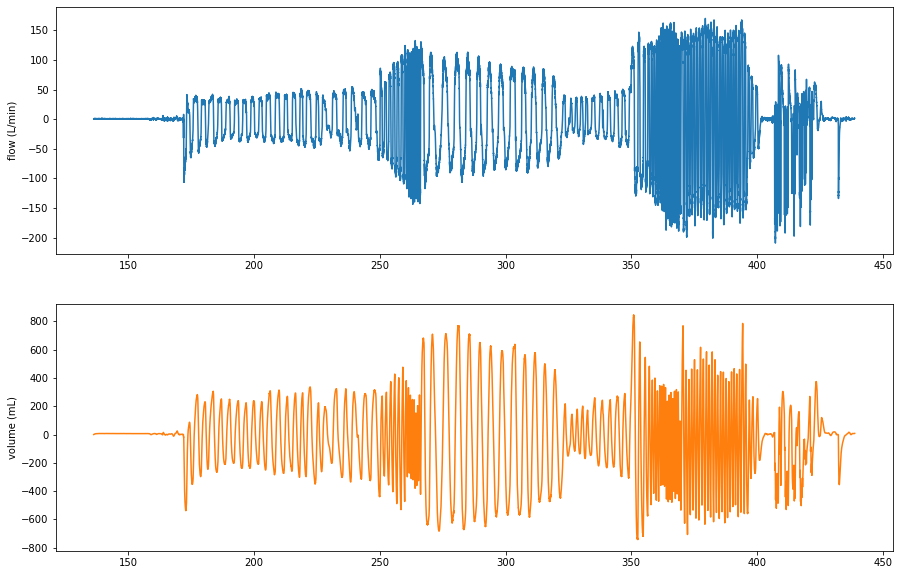

In [7]:
DP2 = compute_volume(DP)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
ax1.plot(DP2.time, DP2.flow)
ax1.set_ylabel("flow (L/min)")
ax2.plot(DP2.time, DP2.filtered, c="#ff7f0e")
ax2.set_ylabel("volume (mL)")
fig.savefig("Philippe_DP_absP_volume2.png")

In [8]:
def smooth_derivative(times, values, sig):
    window_width = int(np.ceil(4*sig/np.min(times[1:] - times[:-1])))
    windowed_times  = np.lib.stride_tricks.as_strided(times,
                                                      (len(times) - window_width + 1, window_width),
                                                      (times.itemsize, times.itemsize))
    windowed_values = np.lib.stride_tricks.as_strided(values,
                                                      (len(values) - window_width + 1, window_width),
                                                      (values.itemsize, values.itemsize))

    centers = np.mean(windowed_times, axis=1)
    windowed_times_centered = windowed_times - centers[:, np.newaxis]
    windowed_weights = np.exp(-0.5 * windowed_times_centered**2 / sig**2)
    sumw   = np.sum(windowed_weights, axis=1)
    sumwx  = np.sum(windowed_weights * windowed_times_centered, axis=1)
    sumwy  = np.sum(windowed_weights * windowed_values, axis=1)
    sumwxx = np.sum(windowed_weights * windowed_times_centered * windowed_times_centered, axis=1)
    sumwxy = np.sum(windowed_weights * windowed_times_centered * windowed_values, axis=1)
    delta     = (sumw*sumwxx) - (sumwx*sumwx)
    intercept = ((sumwxx*sumwy) - (sumwx*sumwxy)) / delta
    slope     = ((sumw*sumwxy) - (sumwx*sumwy)) / delta
    
    return centers, intercept, slope

In [9]:
def roots(times, values, other, other_threshold):
    lefts, = np.nonzero(np.logical_and(np.sign(values[:-1]) != np.sign(values[1:]), abs(0.5*(other[:-1] + other[1:])) > other_threshold*np.max(abs(other))))
    rights = lefts + 1
    return lefts, rights, 0.5*(times[rights] + times[lefts])

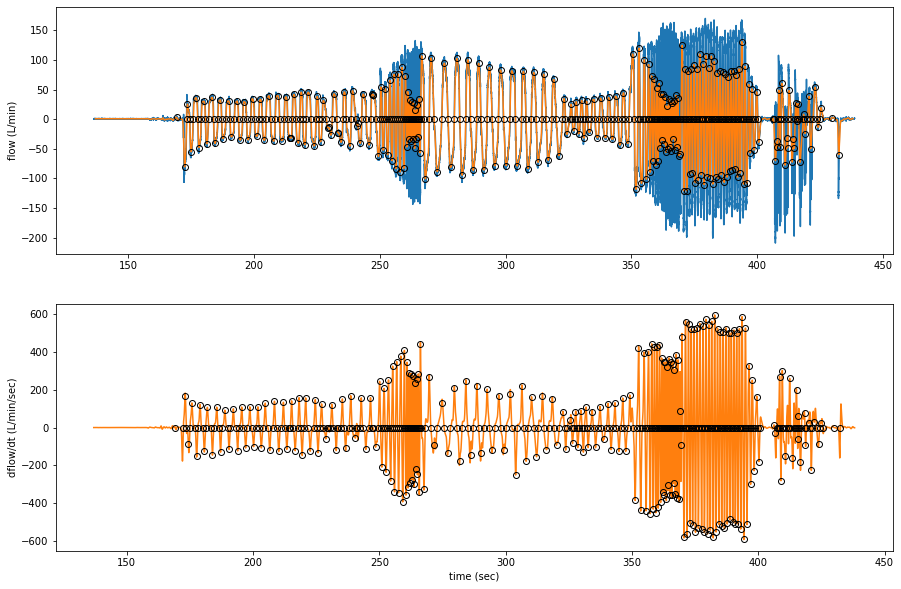

In [11]:
centers, intercept, slope = smooth_derivative(DP2.time, DP2.flow, 0.2)
intercept_lefts, intercept_rights, intercept_roots = roots(centers, intercept, slope, 0.02)
slope_lefts, slope_rights, slope_roots = roots(centers, slope, intercept, 0.02)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
ax1.plot(DP2.time, DP2.flow)
ax1.plot(centers, intercept)
ax1.plot(intercept_roots, np.zeros(len(intercept_roots)), "o", c="black", fillstyle="none")
ax1.plot(slope_roots, 0.5*(intercept[slope_lefts] + intercept[slope_rights]), "o", c="black", fillstyle="none")
ax1.set_ylabel("flow (L/min)")
ax2.plot(centers, slope, c="#ff7f0e")
ax2.plot(slope_roots, np.zeros(len(slope_roots)), "o", c="black", fillstyle="none")
ax2.plot(intercept_roots, 0.5*(slope[intercept_lefts] + slope[intercept_rights]), "o", c="black", fillstyle="none")
ax2.set_xlabel("time (sec)")
ax2.set_ylabel("dflow/dt (L/min/sec)")
fig.savefig("Philippe_DP_absP_turningpoints.png")

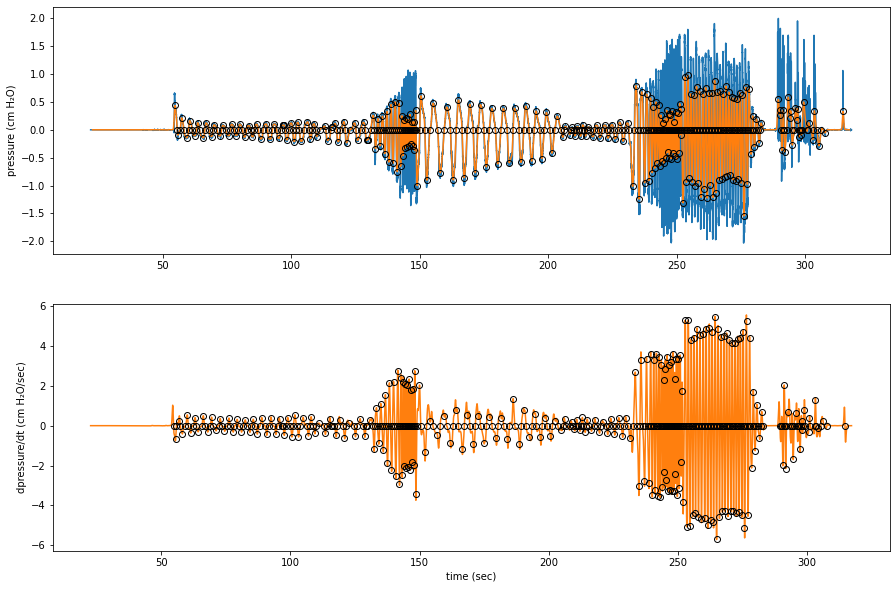

In [12]:
centers, intercept, slope = smooth_derivative(absP.time, absP.pressure, 0.2)
intercept_lefts, intercept_rights, intercept_roots = roots(centers, intercept, slope, 0.02)
slope_lefts, slope_rights, slope_roots = roots(centers, slope, intercept, 0.02)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
ax1.plot(absP.time, absP.pressure)
ax1.plot(centers, intercept)
ax1.plot(intercept_roots, np.zeros(len(intercept_roots)), "o", c="black", fillstyle="none")
ax1.plot(slope_roots, 0.5*(intercept[slope_lefts] + intercept[slope_rights]), "o", c="black", fillstyle="none")
ax1.set_ylabel("pressure (cm H₂O)")
ax2.plot(centers, slope, c="#ff7f0e")
ax2.plot(slope_roots, np.zeros(len(slope_roots)), "o", c="black", fillstyle="none")
ax2.plot(intercept_roots, 0.5*(slope[intercept_lefts] + slope[intercept_rights]), "o", c="black", fillstyle="none")
ax2.set_xlabel("time (sec)")
ax2.set_ylabel("dpressure/dt (cm H₂O/sec)")
fig.savefig("Philippe_DP_absP_turningpoints2.png")

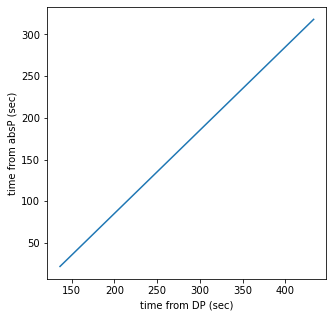

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(DP2.time[:min(len(DP2.time), len(absP.time))], absP.time[:min(len(DP2.time), len(absP.time))])
ax.set_xlabel("time from DP (sec)")
ax.set_ylabel("time from absP (sec)")
fig.savefig("Philippe_DP_absP_timecomparison.png")

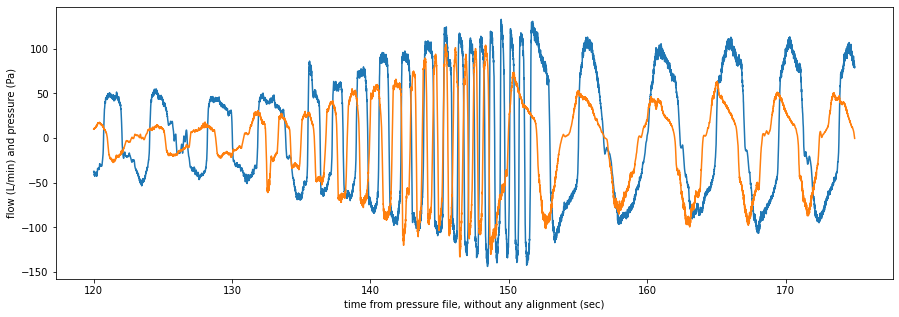

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
cut = np.logical_and(120 < absP.time, absP.time < 175)
ax.plot(absP.time[cut], DP2.flow[:min(len(DP2.time), len(absP.time))][cut])
ax.plot(absP.time[cut], absP.pressure[cut] / 0.0101972)
ax.set_ylabel("flow (L/min) and pressure (Pa)")
ax.set_xlabel("time from pressure file, without any alignment (sec)")
fig.savefig("Philippe_DP_absP_overlay.png")